In [25]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.colors as mcolors
METHODS = ['Base', 'Origin', 'Quant', 'ARKV']
METHOD_ORDER = {"Base": 0, "Origin": 1, "Quant": 2, "ARKV": 3}
# Pleasant gradients: lighter at 512 → darker at 2048
MPL_COLORS = {
    "Base": "#D82E83",  # base color
    "Origin_512": "#8FD19E",  # light green
    "Origin_1024": "#4CAF50",  # medium green
    "Origin_2048": "#2E7D32",  # dark green
    "Quant_512": "#F6B26B",   # light orange
    "Quant_1024": "#F39C12",  # medium orange
    "Quant_2048": "#B85C00",  # dark orange
    "ARKV_512": "#7FC8E7",    # light blue
    "ARKV_1024": "#3498DB",   # medium blue
    "ARKV_2048": "#1B5E7A"    # dark blue
}
# SNS_PALETTE = [MPL_COLORS[m] for m in METHODS]

In [ ]:
longbench_perf = pd.read_csv('data/longbench_perf.csv')
model_names_mapping = {'Meta-Llama-3.1-8B-Instruct': 'Llama-3.1-8B',
               'Llama-3.2-3B-Instruct': 'Llama-3.2-3B',
               'Qwen3-4B-Instruct-2507': 'Qwen3-4B',
               'Qwen3-8B': 'Qwen3-8B'}
longbench_perf['model_name'] = longbench_perf['model'].map(model_names_mapping)
longbench_perf['budget'].fillna(int(512), inplace=True)
longbench_perf.head()

/tmp/ipykernel_3044104/1624752048.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  longbench_perf['budget'].fillna(int(512), inplace=True)


,model,method,budget,task,Task Type,Eval metric,Avg len,Language,performance,model_name
0,Llama-3.2-3B-Instruct,Base,512.0,NarrativeQA,Single-doc QA,F1,18409,EN,25.50,Llama-3.2-3B
1,Llama-3.2-3B-Instruct,Base,512.0,Qasper,Single-doc QA,F1,3619,EN,39.52,Llama-3.2-3B
2,Llama-3.2-3B-Instruct,Base,512.0,MultiFieldQA-en,Single-doc QA,F1,4559,EN,51.15,Llama-3.2-3B
3,Llama-3.2-3B-Instruct,Base,512.0,MultiFieldQA-zh,Single-doc QA,F1,6701,ZH,25.36,Llama-3.2-3B
4,Llama-3.2-3B-Instruct,Base,512.0,HotpotQA,Multi-doc QA,F1,9151,EN,31.81,Llama-3.2-3B


In [28]:
# Build method_budget labels
plot_df = longbench_perf.copy()
plot_df['method_budget'] = np.where(
    plot_df['method'] == 'Base',
    'Base',
    plot_df['method'] + '_' + plot_df['budget'].astype(int).astype(str)
)

# Aggregate mean relative TPS per model and method_budget
model_mb = (
    plot_df.groupby(['model_name', 'method_budget'])['performance']
    .mean()
    .unstack()
)
model_mb

method_budget,ARKV_1024,ARKV_2048,ARKV_512,Base,Origin_1024,Origin_2048,Origin_512,Quant_1024,Quant_2048,Quant_512
model_name,,,,,,,,,,
Llama-3.1-8B,38.022381,38.617619,37.598095,39.042381,38.562857,38.618571,38.201905,13.229048,14.736667,13.145238
Llama-3.2-3B,37.521905,38.087143,36.719524,38.660476,37.641429,37.970476,37.329048,14.119048,15.774286,14.033333
Qwen3-4B,38.113333,38.799048,37.111429,39.170952,38.174762,38.743333,37.723810,14.608095,16.110000,14.621429
Qwen3-8B,36.862857,37.471429,36.186667,37.831905,37.224762,37.499524,36.831905,17.710952,18.902857,17.688571


In [19]:
model_mb_rel = model_mb.div(model_mb['Base'], axis=0)
model_mb_rel['Base'] = 1.0  # Ensure Base is exactly 1.0
model_mb_rel

method_budget,Base,Origin_512.0,Origin_1024.0,Origin_2048.0,Quant_512.0,Quant_1024.0,Quant_2048.0,ARKV_512.0,ARKV_1024.0,ARKV_2048.0
model,,,,,,,,,,
Llama-3.2-3B-Instruct,1.0,0.965561,0.973641,0.982152,0.362989,0.365206,0.408021,0.949795,0.970549,0.985170
Meta-Llama-3.1-8B-Instruct,1.0,0.978473,0.987718,0.989145,0.336692,0.338838,0.377453,0.963007,0.973875,0.989120
Qwen3-4B-Instruct-2507,1.0,0.963056,0.974568,0.989083,0.373272,0.372932,0.411274,0.947422,0.973000,0.990506
Qwen3-8B,1.0,0.973567,0.983952,0.991214,0.467557,0.468149,0.499654,0.956512,0.974385,0.990472


<Figure size 1400x700 with 0 Axes>

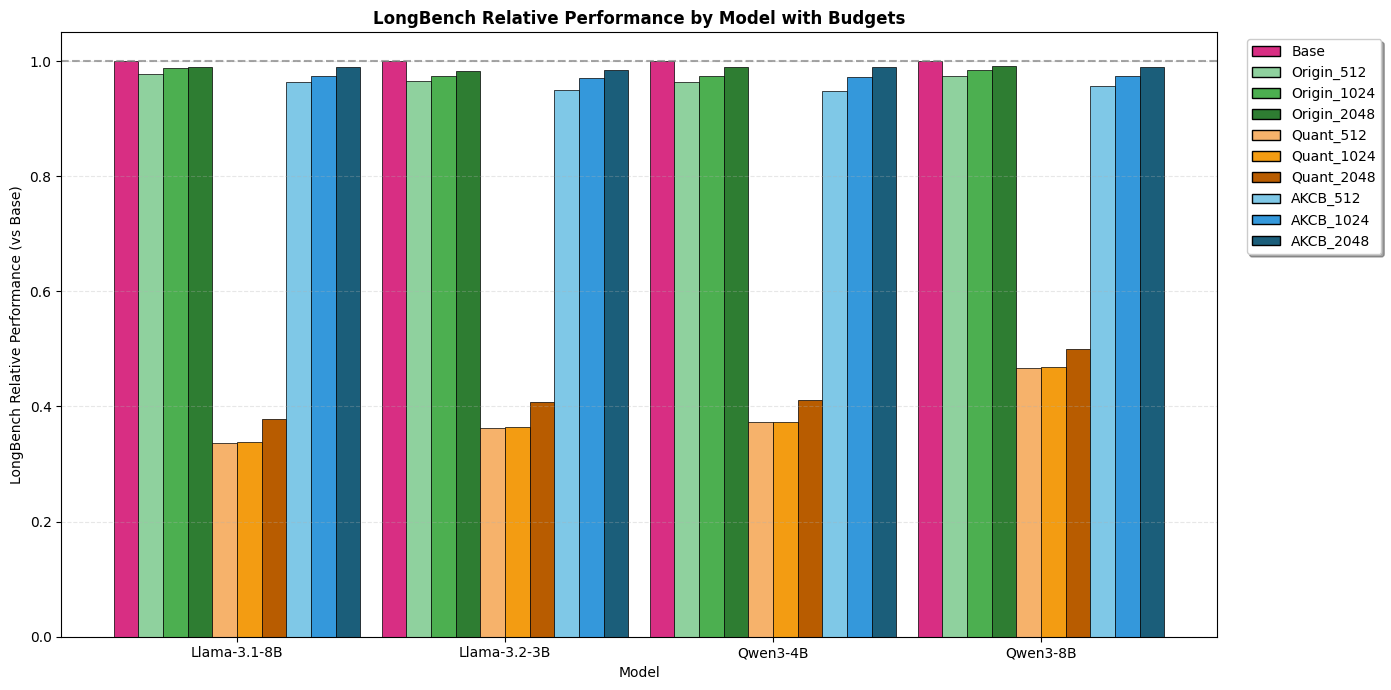

In [29]:
# Combined per-model grouped bar chart with budgets per method
order_cols = [
    'Base',
    'Origin_512', 'Origin_1024', 'Origin_2048',
    'Quant_512', 'Quant_1024', 'Quant_2048',
    'ARKV_512', 'ARKV_1024', 'ARKV_2048'
]
color_map = {
    'Base': MPL_COLORS['Base'],
    'Origin_512': MPL_COLORS['Origin_512'],
    'Origin_1024': MPL_COLORS['Origin_1024'],
    'Origin_2048': MPL_COLORS['Origin_2048'],
    'Quant_512': MPL_COLORS['Quant_512'],
    'Quant_1024': MPL_COLORS['Quant_1024'],
    'Quant_2048': MPL_COLORS['Quant_2048'],
    'ARKV_512': MPL_COLORS['ARKV_512'],
    'ARKV_1024': MPL_COLORS['ARKV_1024'],
    'ARKV_2048': MPL_COLORS['ARKV_2048'],
}

# Build method_budget labels
plot_df = longbench_perf.copy()
plot_df['method_budget'] = np.where(
    plot_df['method'] == 'Base',
    'Base',
    plot_df['method'] + '_' + plot_df['budget'].astype(int).astype(str)
)

# Aggregate mean relative TPS per model and method_budget
model_mb = (
    plot_df.groupby(['model_name', 'method_budget'])['performance']
    .mean()
    .unstack()
)
model_mb = model_mb.div(model_mb['Base'], axis=0)
model_mb['Base'] = 1.0  # Ensure Base is exactly 1.0

# Ensure all columns in desired order exist
for c in order_cols:
    if c not in model_mb.columns:
        model_mb[c] = np.nan
model_mb = model_mb[order_cols]

# Plot
plt.figure(figsize=(14, 7))
fig, ax = plt.subplots(figsize=(14, 7))
models = list(model_mb.index)
n_bars_per_model = len(order_cols)
bar_width = 0.08
model_spacing = 0.15  # extra gap between model groups

# Compute x positions: consecutive bars per model, then a gap
positions = []
current_x = 0.0
for _ in models:
    # bars for this model
    positions.extend([current_x + i * bar_width for i in range(n_bars_per_model)])
    # add spacing before next model
    current_x = positions[-1] + model_spacing

# Draw bars
colors = [color_map[c] for c in order_cols]
for mi, model in enumerate(models):
    start = mi * n_bars_per_model
    end = start + n_bars_per_model
    yvals = model_mb.loc[model, order_cols].values
    ax.bar(positions[start:end], yvals, width=bar_width, color=colors,
           edgecolor='black', linewidth=0.5)

# Reference line at 1.0
ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)

# X ticks: put one tick centered under each model group
model_centers = []
for mi in range(len(models)):
    start = mi * n_bars_per_model
    end = start + n_bars_per_model
    center = np.mean(positions[start:end])
    model_centers.append(center)
ax.set_xticks(model_centers)
ax.set_xticklabels(models, rotation=0)

# Legend: show one patch per column type
from matplotlib.patches import Patch
legend_handles = [Patch(facecolor=color_map[c], edgecolor='black', label=c) for c in order_cols]
ax.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1.02, 1.0), frameon=True, shadow=True)

ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.title('LongBench Relative Performance by Model with Budgets', fontweight='bold')
plt.xlabel('Model')
plt.ylabel('LongBench Relative Performance (vs Base)')
longbench_root = Path('/var/scratch/jle385/thesis/adkv/experiments/analysis/plots/longbench')
longbench_root.mkdir(parents=True, exist_ok=True)
plt.tight_layout()
plt.savefig(longbench_root / 'longbench_relative_per_model_grouped_budgets.png', dpi=300, bbox_inches='tight')

<Figure size 1400x700 with 0 Axes>

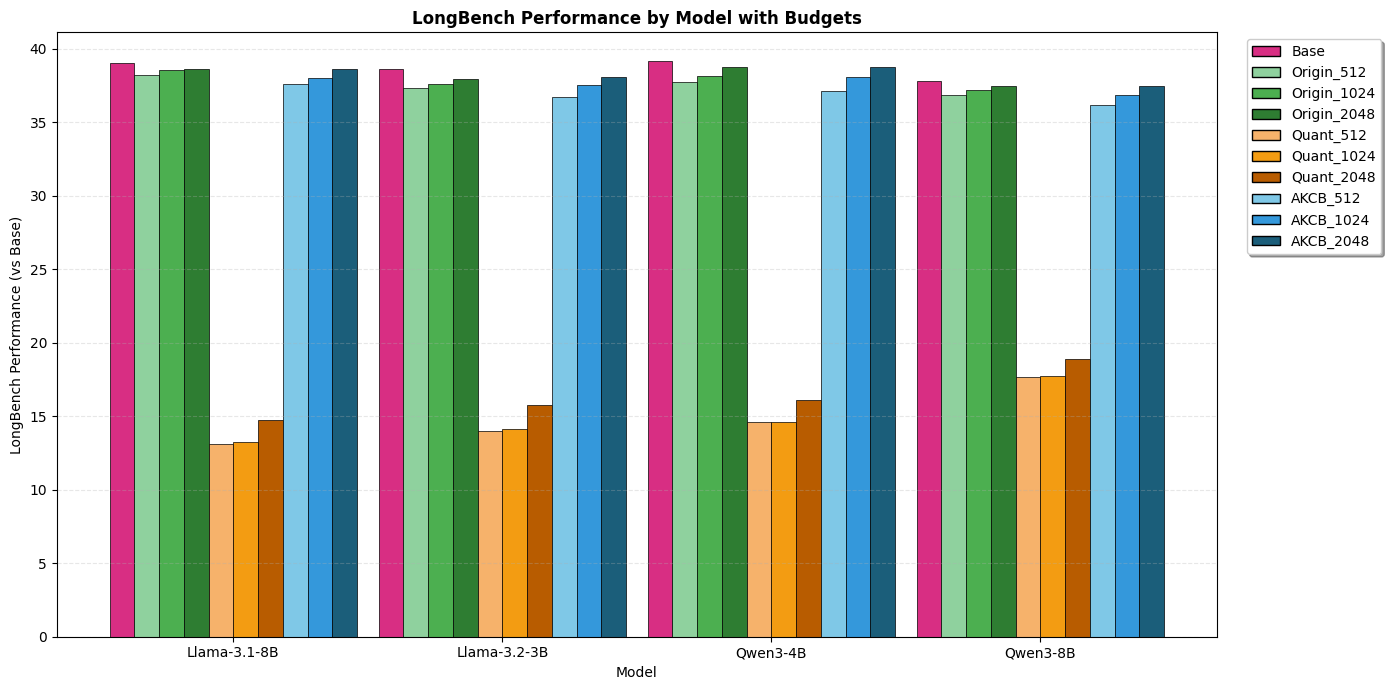

In [30]:
# Combined per-model grouped bar chart with budgets per method
order_cols = [
    'Base',
    'Origin_512', 'Origin_1024', 'Origin_2048',
    'Quant_512', 'Quant_1024', 'Quant_2048',
    'ARKV_512', 'ARKV_1024', 'ARKV_2048'
]
color_map = {
    'Base': MPL_COLORS['Base'],
    'Origin_512': MPL_COLORS['Origin_512'],
    'Origin_1024': MPL_COLORS['Origin_1024'],
    'Origin_2048': MPL_COLORS['Origin_2048'],
    'Quant_512': MPL_COLORS['Quant_512'],
    'Quant_1024': MPL_COLORS['Quant_1024'],
    'Quant_2048': MPL_COLORS['Quant_2048'],
    'ARKV_512': MPL_COLORS['ARKV_512'],
    'ARKV_1024': MPL_COLORS['ARKV_1024'],
    'ARKV_2048': MPL_COLORS['ARKV_2048'],
}

# Build method_budget labels
plot_df = longbench_perf.copy()
plot_df['method_budget'] = np.where(
    plot_df['method'] == 'Base',
    'Base',
    plot_df['method'] + '_' + plot_df['budget'].astype(int).astype(str)
)

# Aggregate mean relative TPS per model and method_budget
model_mb = (
    plot_df.groupby(['model_name', 'method_budget'])['performance']
    .mean()
    .unstack()
)
# Ensure all columns in desired order exist
for c in order_cols:
    if c not in model_mb.columns:
        model_mb[c] = np.nan
model_mb = model_mb[order_cols]

# Plot
plt.figure(figsize=(14, 7))
fig, ax = plt.subplots(figsize=(14, 7))
models = list(model_mb.index)
n_bars_per_model = len(order_cols)
bar_width = 0.08
model_spacing = 0.15  # extra gap between model groups

# Compute x positions: consecutive bars per model, then a gap
positions = []
current_x = 0.0
for _ in models:
    # bars for this model
    positions.extend([current_x + i * bar_width for i in range(n_bars_per_model)])
    # add spacing before next model
    current_x = positions[-1] + model_spacing

# Draw bars
colors = [color_map[c] for c in order_cols]
for mi, model in enumerate(models):
    start = mi * n_bars_per_model
    end = start + n_bars_per_model
    yvals = model_mb.loc[model, order_cols].values
    ax.bar(positions[start:end], yvals, width=bar_width, color=colors,
           edgecolor='black', linewidth=0.5)

# Reference line at 1.0
# ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)

# X ticks: put one tick centered under each model group
model_centers = []
for mi in range(len(models)):
    start = mi * n_bars_per_model
    end = start + n_bars_per_model
    center = np.mean(positions[start:end])
    model_centers.append(center)
ax.set_xticks(model_centers)
ax.set_xticklabels(models, rotation=0)

# Legend: show one patch per column type
from matplotlib.patches import Patch
legend_handles = [Patch(facecolor=color_map[c], edgecolor='black', label=c) for c in order_cols]
ax.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1.02, 1.0), frameon=True, shadow=True)

ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.title('LongBench Performance by Model with Budgets', fontweight='bold')
plt.xlabel('Model')
plt.ylabel('LongBench Performance (vs Base)')
longbench_root = Path('/var/scratch/jle385/thesis/adkv/experiments/analysis/plots/longbench')
longbench_root.mkdir(parents=True, exist_ok=True)
plt.tight_layout()
plt.savefig(longbench_root / 'longbench_per_model_grouped_budgets.png', dpi=300, bbox_inches='tight')